In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations_JB import *
from proj1_helpers import *
%load_ext autoreload
%autoreload 2

In [14]:
y, x, ids =  load_csv_data("train.csv")
y_test, x_test, ids_test = load_csv_data("test.csv")
data_list = full_data_processing(y,x,ids)

The cell below contains a function to dislay the histogram of a choosen feature

In [4]:
def histo(index_feature, y, x,bins):
    
    x_array = x[:,index_feature]
    x_mask = np.where(yb>0, True, False) # Transforming in a boolean mask
    
    print np.mean(x_array)
    print np.std(x_array)
    
    # Displaying the histogram for the whole data
    plt.hist(x_array,bins)
    plt.ylabel("Feature "+str(i))
    # Displaying the histogram for the data where y = 1
    plt.figure()
    plt.hist(x_array[x_mask],bins)
    # Displaying the histogram for the data where y = -1
    plt.figure()
    plt.hist(x_array[np.invert(x_mask)],bins)
    plt.show()

The cell below contains functions to split the data according to :
    - The value of PRI_jet_num (0,1,2 or 3)
    - The value of DER_Mass_MMC (-999 or well-defined value)

In [13]:
def splitting1(y,x,ids):
    for i in range(4):
        mask = (x[:,22] == i)
        yield y[mask], x[mask], ids[mask]
        
def splitting2(y,x,ids):
    feature0 = x[:,0]
    masks = [0,0]
    mask1 = np.where(feature0==-999,False,True)
    masks[0] = mask1
    masks[1] = np.invert(mask1)
    for mask in masks:
        yield y[mask], x[mask], ids[mask]
        
def full_splitting(y,x,ids):
    """
    Will yields in this order :
    split_id = 0) Data with a defined feature0 ans with PRI_jet_num = 0
    split_id = 1) Data with a defined feature0 ans with PRI_jet_num = 1
    split_id = 2) Data with a defined feature0 ans with PRI_jet_num = 2
    split_id = 3) Data with a defined feature0 ans with PRI_jet_num = 3
    split_id = 4) Data with an undefined feature0 ans with PRI_jet_num = 0
    split_id = 5) Data with an undefined feature0 ans with PRI_jet_num = 1
    split_id = 6) Data with an undefined feature0 ans with PRI_jet_num = 2
    split_id = 7) Data with an undefined feature0 ans with PRI_jet_num = 3
    """
    split_id = -1
    for y2,x2,ids2 in splitting2(y,x,ids):
        for y1,x1,ids1 in splitting1(y2,x2,ids2):
            split_id+=1
            yield y1,x1,ids1, split_id           

The cell below contains functions to prepare the data :
    - Remove some unrelevant features if needed
    - Transform the angle features in two features by applying sin() and cos()
    - Applying the absolute value to symetric features
    

In [6]:
def remove_features_jetnum0(x):
    """
    Remove the useless features if the jet num feature is equal to 0
    """
    useless_features_index = [4, 5, 6, 12,22, 23, 24, 25 , 26, 27, 28,29,33,34] 
    mask = np.ones(int(x.shape[1]), dtype=bool)
    mask[(useless_features_index)] = False
    return x[:,mask]


def remove_features_jetnum1(x):
    """
    Remove the useless features if the jet num feature is equal to 1
    """
    useless_features_index = [4, 5, 6, 12,22, 26, 27, 28,34]
    mask = np.ones(int(x.shape[1]), dtype=bool)
    mask[(useless_features_index)] = False
    return x[:,mask]

def remove_features_jetnum(x,split_id):
    
    """
    Remove the useless features if the jet num feature is equal to 0 (--> split_id equal to 0 or 4)
    Remove the useless features if the jet num feature is equal to 1 (--> split_id equal to 1 or 5)
    """
    useless_features_index = []
    if split_id in [0,4]:
        useless_features_index = [4, 5, 6, 12,22, 23, 24, 25 , 26, 27, 28,29,33,34] 
    elif split_id in [1,5]:
        useless_features_index = [4, 5, 6, 12,22, 26, 27, 28,34]
    else:
        return x
    mask = np.ones(int(x.shape[1]), dtype=bool)
    mask[(useless_features_index)] = False
    return x[:,mask]

def angle_processing(x):
    
    angle_features = [15, 18, 20, 25, 28]
    new_x = np.zeros((x.shape[0], x.shape[1] + len(angle_features) ))
    
    for k in range(x.shape[1]):
        if k not in angle_features:
            new_x[:, k] = x[:, k]
        
    for idx, column in enumerate(angle_features): 
        
        new_x[:, column] = np.cos(x[:, column])
        new_x[:, x.shape[1] + idx] = np.sin(x[:, column])
    
    return new_x

def absolute_value(x,split_id):
    
    list0 = [10,11,13,14,16,18,19,20]
    list1 = [10,11,13,14,16,19,20,22,23,24,25]
    list2 = [14,15,17,18,20,24,25,27,28,30,31,32,33,34]
    list3 = [14,15,17,18,20,24,25,27,28,30,31,32,33,34]

    full_list = [list0, list1, list2, list3]
    
    list_ = full_list[split_id%4]

    for index in np.array(list_):
        x[:,index] = np.absolute(x[:,index])
    return x    

def full_data_processing(y,x,ids):
    data_list = []
    for y0,x0,ids0, split_id in full_splitting(y,x,ids):
        
        x0 = angle_processing(x0)
        x0 = remove_features_jetnum(x0,split_id)
        x0 = standardize(x0)
        x0 = absolute_value(x0,split_id)
    
        data_list.append([y0,x0,ids0])
        
    return data_list  

The cell below contains functions to do the regression

In [7]:
def regression(y_test, x_test, y_train, x_train,lambda_):
    
    # Here we can choose which method to use :
    
    w, train_loss = ridge_regression(y_train, x_train, lambda_)   
    #w, train_loss = least_squares_GD(y_train, x_train, 0*np.random.rand(int(x_train.shape[1])), 1000, 0.00000000001,computeLoss = True);
    
    test_loss = compute_loss(y_test, x_test, w)
    y_pred = predict_labels(w, x_test)
    
    return w, train_loss, test_loss, y_pred 

def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

The cell below contains functions to train the model using K-Fold Cross-Validation

In [20]:
def K_split(y,x,k):
    n = int(y.shape[0])
    bool_mask = np.ones(n,dtype=bool)
    bool_mask[::k] = 0
    
    # We yield ... train then ... test
    
    for i in range(k):
        yield y[bool_mask], standardize(x[bool_mask]), y[np.invert(bool_mask)], standardize(x[np.invert(bool_mask)])
        bool_mask[i::k] = 1
        bool_mask[i+1::k] = 0 
        
def Kfold_regression(y, x, k,degree,lambda_):

    train_loss_list = []
    test_loss_list = []
    score_list = []
    
    for y_train, x_train, y_test, x_test, in K_split(y,x,k):
        x_train_poly = build_poly(x_train,degree)
        x_test_poly = build_poly(x_test,degree)
        w, train_loss, test_loss, y_pred = regression(y_test, x_test_poly, y_train, x_train_poly,lambda_)
        train_loss_list+=[train_loss]
        test_loss_list+=[test_loss]
        score_list+=[np.mean(y_pred == y_test)]
        
    return train_loss_list, test_loss_list,score_list  

The cell below contain a function to test the 2 parameters : the degree and lambda_

In [57]:
def param_test_simultane(y, x, k):
    
    lambda_list = np.logspace(-10, 1, 12)
    degree_list = np.arange(1,5)
    
    final_train_loss_list = np.zeros((len(degree_list),len(lambda_list)))
    final_test_loss_list = np.zeros((len(degree_list),len(lambda_list)))
    final_score_list = np.zeros((len(degree_list),len(lambda_list)))

    
    
    for i, lambda_ in enumerate(lambda_list):
        for j,degree in enumerate(degree_list):
            
            train_loss_list, test_loss_list,score_list = Kfold_regression(y, x,k,degree,lambda_)
            train_loss, test_loss, score = np.mean(train_loss_list), np.mean(test_loss_list), np.mean(score_list)
            final_train_loss_list[j,i]=train_loss
            final_test_loss_list[j,i]=test_loss
            final_score_list[j,i]=score
            
            print ("Degree = " + str(degree) + " and Lambda = " + str(lambda_) + ", Score = " + str(score))
    
        """
        plt.figure()
        plt.plot(degree_list,final_train_loss_list[:,i])
        plt.ylabel("Train Loss")
        plt.figure()
        plt.plot(degree_list,final_test_loss_list[:,i])
        plt.ylabel("Test Loss")
        plt.figure()
        plt.plot(degree_list,final_score_list[:,i], label = str(lambda_))
        plt.ylabel("Score for lambda = " + str(lambda_))
        plt.ylim(0.6, 1)
        plt.legend()
        plt.show()
        """

    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(10,10)
    for i, lambda_ in enumerate(lambda_list):
        plt.plot(degree_list, final_score_list[:,i], label = str(lambda_))
        plt.ylabel("Score")
        plt.ylim(0.6, 1)
    plt.legend()
    plt.show()
    
    return final_train_loss_list, final_test_loss_list, final_score_list

The cell below contain a function to make a csv file to upload it on Kaggle

In [55]:
def submission(deg_list, lambda_list,y, x, ids, y_test, x_test, ids_test):
    
    data_list_train = full_data_processing(y,x,ids)
    data_list_test = full_data_processing(y_test,x_test,ids_test)
    
    ids_final = np.array([])
    y_pred_final = np.array([])

    for i in range(len(data_list_train)):
        degree = deg_list[i]
        lambda_ = lambda_list[i]
        x_poly = build_poly(data_list_train[i][1], degree)
        x_poly_test = build_poly(data_list_test[i][1], degree)
        
        w, train_loss, test_loss, y_pred = regression(data_list_test[i][0], x_poly_test, data_list_train[i][0], x_poly, lambda_)
    
        ids_final = np.append(ids_final, data_list_test[i][2])
        y_pred_final = np.append(y_pred_final, y_pred)
        
    create_csv_submission(ids_final, y_pred_final, "prediction.csv")        

In [61]:
deg_list = [12,12,12,12,8,4,5,4]
lambda_list = [1e-05,1e-05,0.001,0.0001,1e-05,1e-05,0.0001,0.001]
submission(deg_list,lambda_list,y, x, ids, y_test, x_test, ids_test)

Degree = 4 and Lambda = 1e-10, Score = 0.7155696328572928
Degree = 5 and Lambda = 1e-10, Score = 0.7050125380789436
Degree = 6 and Lambda = 1e-10, Score = 0.6957978400116823
Degree = 7 and Lambda = 1e-10, Score = 0.6984939059299425
Degree = 8 and Lambda = 1e-10, Score = 0.7020174821494459
Degree = 9 and Lambda = 1e-10, Score = 0.7017871827404462
Degree = 10 and Lambda = 1e-10, Score = 0.6967999792383321
Degree = 11 and Lambda = 1e-10, Score = 0.6965696941541073
Degree = 12 and Lambda = 1e-10, Score = 0.6901193471060184
Degree = 13 and Lambda = 1e-10, Score = 0.6351509295547099
Degree = 14 and Lambda = 1e-10, Score = 0.6224394569221243
Degree = 15 and Lambda = 1e-10, Score = 0.6141468501364465
Degree = 4 and Lambda = 1e-09, Score = 0.7936304352069862
Degree = 5 and Lambda = 1e-09, Score = 0.7915027036382147
Degree = 6 and Lambda = 1e-09, Score = 0.7922210844971628
Degree = 7 and Lambda = 1e-09, Score = 0.7941047053699434
Degree = 8 and Lambda = 1e-09, Score = 0.7959748719732042
Degree =

Degree = 14 and Lambda = 10.0, Score = 0.7356953964047186
Degree = 15 and Lambda = 10.0, Score = 0.7400051713760334


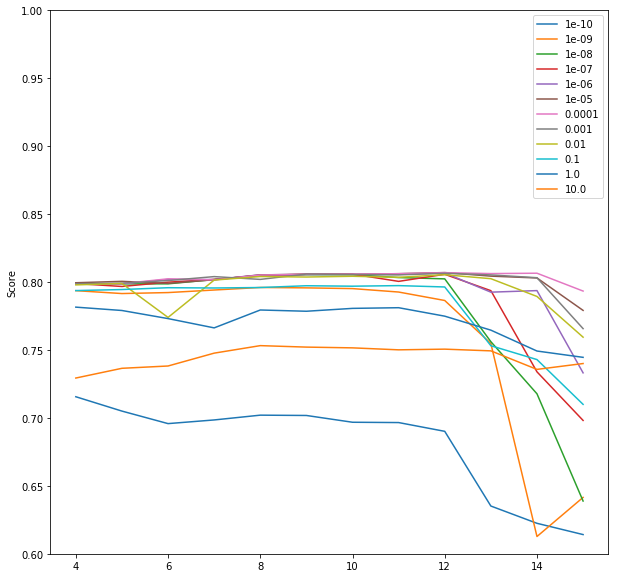

Degree = 4 and Lambda = 1e-10, Score = 0.6745460659377917
Degree = 5 and Lambda = 1e-10, Score = 0.66980191863945
Degree = 6 and Lambda = 1e-10, Score = 0.6712879003105071
Degree = 7 and Lambda = 1e-10, Score = 0.6811048941366287
Degree = 8 and Lambda = 1e-10, Score = 0.7016958220182937
Degree = 9 and Lambda = 1e-10, Score = 0.7072832384593065
Degree = 10 and Lambda = 1e-10, Score = 0.7128274828957609
Degree = 11 and Lambda = 1e-10, Score = 0.7316034444158642
Degree = 12 and Lambda = 1e-10, Score = 0.6796435344014253
Degree = 13 and Lambda = 1e-10, Score = 0.6699270449235054
Degree = 14 and Lambda = 1e-10, Score = 0.518291612500123
Degree = 15 and Lambda = 1e-10, Score = 0.5975383452377215
Degree = 4 and Lambda = 1e-09, Score = 0.7598812335924819
Degree = 5 and Lambda = 1e-09, Score = 0.7619817431059364
Degree = 6 and Lambda = 1e-09, Score = 0.7654112049756104
Degree = 7 and Lambda = 1e-09, Score = 0.7731989467412862
Degree = 8 and Lambda = 1e-09, Score = 0.7842588711302212
Degree = 9 

Degree = 14 and Lambda = 10.0, Score = 0.7066673984761268
Degree = 15 and Lambda = 10.0, Score = 0.6979511915287034


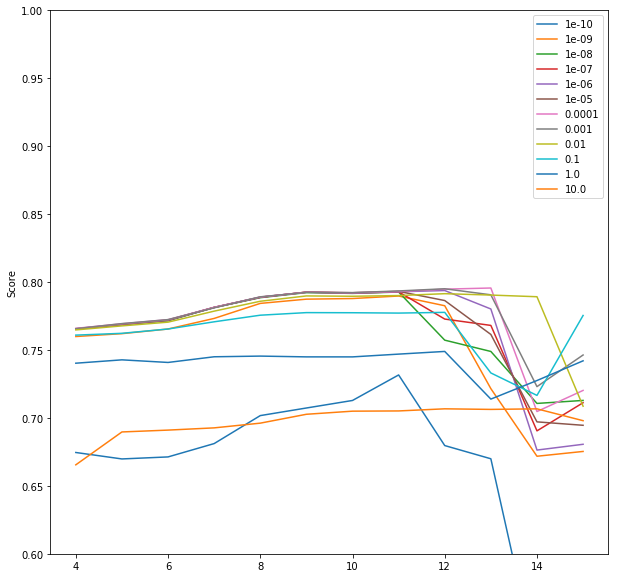

Degree = 4 and Lambda = 1e-10, Score = 0.7562798650216257
Degree = 5 and Lambda = 1e-10, Score = 0.7622675591175915
Degree = 6 and Lambda = 1e-10, Score = 0.7741597168339278
Degree = 7 and Lambda = 1e-10, Score = 0.746223256454643
Degree = 8 and Lambda = 1e-10, Score = 0.7747716990348446
Degree = 9 and Lambda = 1e-10, Score = 0.7636389280473845
Degree = 10 and Lambda = 1e-10, Score = 0.7692475022854904
Degree = 11 and Lambda = 1e-10, Score = 0.7878644754340723
Degree = 12 and Lambda = 1e-10, Score = 0.7875696503733182
Degree = 13 and Lambda = 1e-10, Score = 0.7743477949819081
Degree = 14 and Lambda = 1e-10, Score = 0.6566932832403346
Degree = 15 and Lambda = 1e-10, Score = 0.6169448760414878
Degree = 4 and Lambda = 1e-09, Score = 0.8017162464437256
Degree = 5 and Lambda = 1e-09, Score = 0.8038036583424453
Degree = 6 and Lambda = 1e-09, Score = 0.8079152390354077
Degree = 7 and Lambda = 1e-09, Score = 0.816602287218923
Degree = 8 and Lambda = 1e-09, Score = 0.8244669589789684
Degree = 9

Degree = 14 and Lambda = 10.0, Score = 0.7231322651279832
Degree = 15 and Lambda = 10.0, Score = 0.7179036429991439


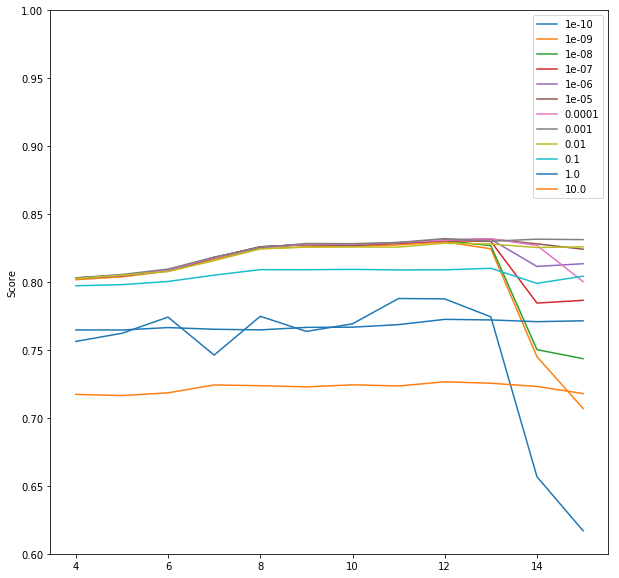

Degree = 4 and Lambda = 1e-10, Score = 0.7496002470063189
Degree = 5 and Lambda = 1e-10, Score = 0.7619277335437005
Degree = 6 and Lambda = 1e-10, Score = 0.7633297086743441
Degree = 7 and Lambda = 1e-10, Score = 0.7755602123056219
Degree = 8 and Lambda = 1e-10, Score = 0.765167405733625
Degree = 9 and Lambda = 1e-10, Score = 0.777591370349953
Degree = 10 and Lambda = 1e-10, Score = 0.7837304051338903
Degree = 11 and Lambda = 1e-10, Score = 0.7685031773821279
Degree = 12 and Lambda = 1e-10, Score = 0.7634752531483825
Degree = 13 and Lambda = 1e-10, Score = 0.6988401427785821
Degree = 14 and Lambda = 1e-10, Score = 0.6535084169271014
Degree = 15 and Lambda = 1e-10, Score = 0.537004770167901
Degree = 4 and Lambda = 1e-09, Score = 0.7930102220768319
Degree = 5 and Lambda = 1e-09, Score = 0.7946055460087131
Degree = 6 and Lambda = 1e-09, Score = 0.7947022484552849
Degree = 7 and Lambda = 1e-09, Score = 0.8034031829015715
Degree = 8 and Lambda = 1e-09, Score = 0.8142312346210016
Degree = 9 

Degree = 14 and Lambda = 10.0, Score = 0.7218060342999765
Degree = 15 and Lambda = 10.0, Score = 0.7188086651225687


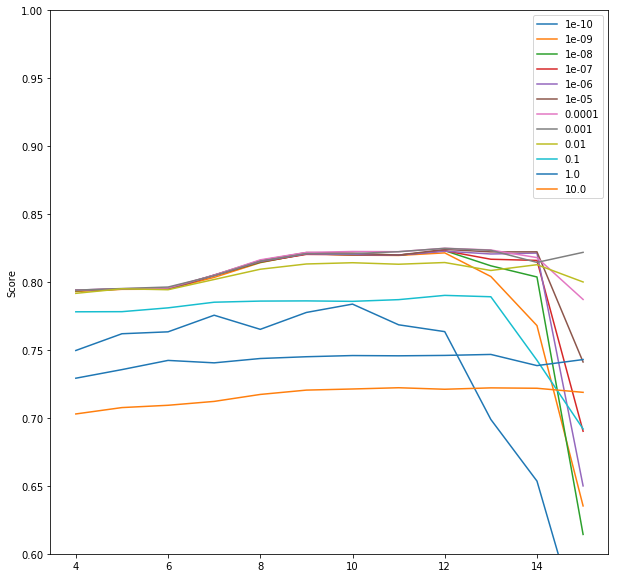

Degree = 4 and Lambda = 1e-10, Score = 0.6630957032819812
Degree = 5 and Lambda = 1e-10, Score = 0.6475923569800506
Degree = 6 and Lambda = 1e-10, Score = 0.6488173106310947
Degree = 7 and Lambda = 1e-10, Score = 0.6501954505404837
Degree = 8 and Lambda = 1e-10, Score = 0.6447979652643915
Degree = 9 and Lambda = 1e-10, Score = 0.6540670089807951
Degree = 10 and Lambda = 1e-10, Score = 0.6116082629547122
Degree = 11 and Lambda = 1e-10, Score = 0.6051772189135045
Degree = 12 and Lambda = 1e-10, Score = 0.5098898525729118
Degree = 13 and Lambda = 1e-10, Score = 0.5497006923420905
Degree = 14 and Lambda = 1e-10, Score = 0.5151829302459426
Degree = 15 and Lambda = 1e-10, Score = 0.5971003635210159
Degree = 4 and Lambda = 1e-09, Score = 0.8318363641524739
Degree = 5 and Lambda = 1e-09, Score = 0.8143423439565805
Degree = 6 and Lambda = 1e-09, Score = 0.8143040122171933
Degree = 7 and Lambda = 1e-09, Score = 0.8141509578643521
Degree = 8 and Lambda = 1e-09, Score = 0.8107441992444242
Degree =

Degree = 14 and Lambda = 10.0, Score = 0.7107137484192004
Degree = 15 and Lambda = 10.0, Score = 0.6949309998792449


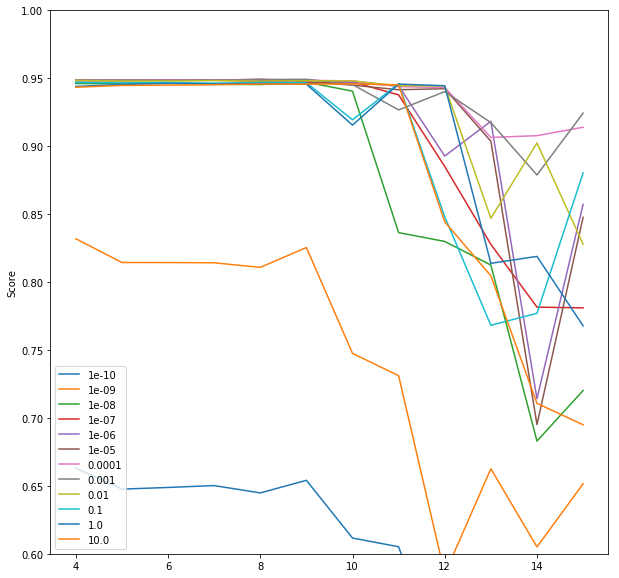

Degree = 4 and Lambda = 1e-10, Score = 0.5669224055821993
Degree = 5 and Lambda = 1e-10, Score = 0.5686399892585459
Degree = 6 and Lambda = 1e-10, Score = 0.5773694137096199
Degree = 7 and Lambda = 1e-10, Score = 0.5872903633212911
Degree = 8 and Lambda = 1e-10, Score = 0.5443004208468126
Degree = 9 and Lambda = 1e-10, Score = 0.5932434785527568
Degree = 10 and Lambda = 1e-10, Score = 0.5772378728564296
Degree = 11 and Lambda = 1e-10, Score = 0.5771071711793362
Degree = 12 and Lambda = 1e-10, Score = 0.6321023668961813
Degree = 13 and Lambda = 1e-10, Score = 0.5753867552836625
Degree = 14 and Lambda = 1e-10, Score = 0.5514445367538151
Degree = 15 and Lambda = 1e-10, Score = 0.6701022536074083
Degree = 4 and Lambda = 1e-09, Score = 0.7620793105329188
Degree = 5 and Lambda = 1e-09, Score = 0.7737137528374641
Degree = 6 and Lambda = 1e-09, Score = 0.7889195188164259
Degree = 7 and Lambda = 1e-09, Score = 0.7960610122981255
Degree = 8 and Lambda = 1e-09, Score = 0.7924880102715154
Degree =

Degree = 14 and Lambda = 10.0, Score = 0.9057137402498228
Degree = 15 and Lambda = 10.0, Score = 0.890635529037591


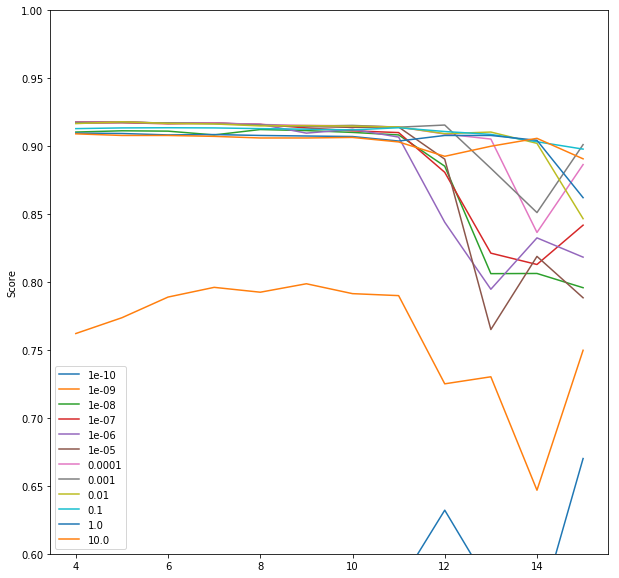

Degree = 4 and Lambda = 1e-10, Score = 0.5677506775067751
Degree = 5 and Lambda = 1e-10, Score = 0.5711382113821138
Degree = 6 and Lambda = 1e-10, Score = 0.5674119241192412
Degree = 7 and Lambda = 1e-10, Score = 0.5741869918699187
Degree = 8 and Lambda = 1e-10, Score = 0.586720867208672
Degree = 9 and Lambda = 1e-10, Score = 0.5511517615176152
Degree = 10 and Lambda = 1e-10, Score = 0.5433604336043362
Degree = 11 and Lambda = 1e-10, Score = 0.5491192411924118
Degree = 12 and Lambda = 1e-10, Score = 0.5992547425474254
Degree = 13 and Lambda = 1e-10, Score = 0.5128726287262872
Degree = 14 and Lambda = 1e-10, Score = 0.5223577235772358
Degree = 15 and Lambda = 1e-10, Score = 0.5802845528455284
Degree = 4 and Lambda = 1e-09, Score = 0.7083333333333334
Degree = 5 and Lambda = 1e-09, Score = 0.7218834688346881
Degree = 6 and Lambda = 1e-09, Score = 0.6988482384823849
Degree = 7 and Lambda = 1e-09, Score = 0.717140921409214
Degree = 8 and Lambda = 1e-09, Score = 0.7266260162601625
Degree = 9

Degree = 14 and Lambda = 10.0, Score = 0.872628726287263
Degree = 15 and Lambda = 10.0, Score = 0.858739837398374


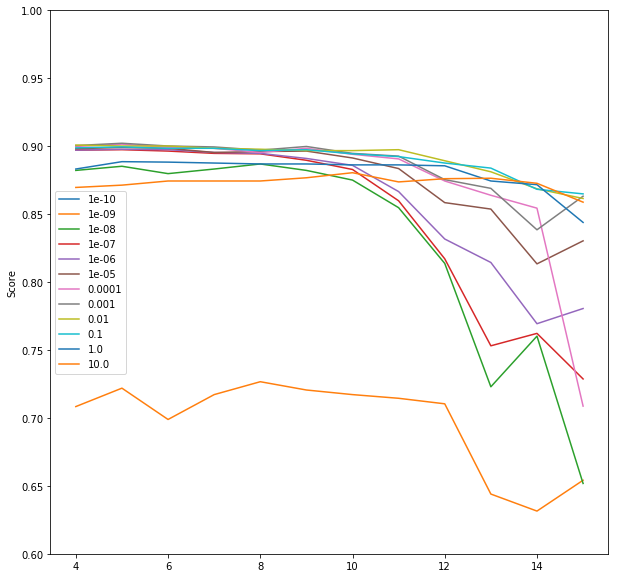

In [48]:
for i in range(7):
    param_test_simultane(data_list[i][0], data_list[i][1],6)

Degree = 4 and Lambda = 1e-10, Score = 0.6567289863182033
Degree = 5 and Lambda = 1e-10, Score = 0.5686640773290325
Degree = 6 and Lambda = 1e-10, Score = 0.578165629834436
Degree = 7 and Lambda = 1e-10, Score = 0.6872634212172081
Degree = 8 and Lambda = 1e-10, Score = 0.5998924766575601
Degree = 9 and Lambda = 1e-10, Score = 0.7089628386162404
Degree = 10 and Lambda = 1e-10, Score = 0.613439869216506
Degree = 11 and Lambda = 1e-10, Score = 0.5748384406920993
Degree = 12 and Lambda = 1e-10, Score = 0.5307977573702863
Degree = 13 and Lambda = 1e-10, Score = 0.6121013133208255
Degree = 14 and Lambda = 1e-10, Score = 0.5591570389388104
Degree = 15 and Lambda = 1e-10, Score = 0.5477271979197526
Degree = 4 and Lambda = 1e-09, Score = 0.9140087554721701
Degree = 5 and Lambda = 1e-09, Score = 0.9167132966876227
Degree = 6 and Lambda = 1e-09, Score = 0.9011470985155197
Degree = 7 and Lambda = 1e-09, Score = 0.8849280800500313
Degree = 8 and Lambda = 1e-09, Score = 0.8646495068189548
Degree = 9

Degree = 14 and Lambda = 10.0, Score = 0.8653709006725695
Degree = 15 and Lambda = 10.0, Score = 0.8748066225601527


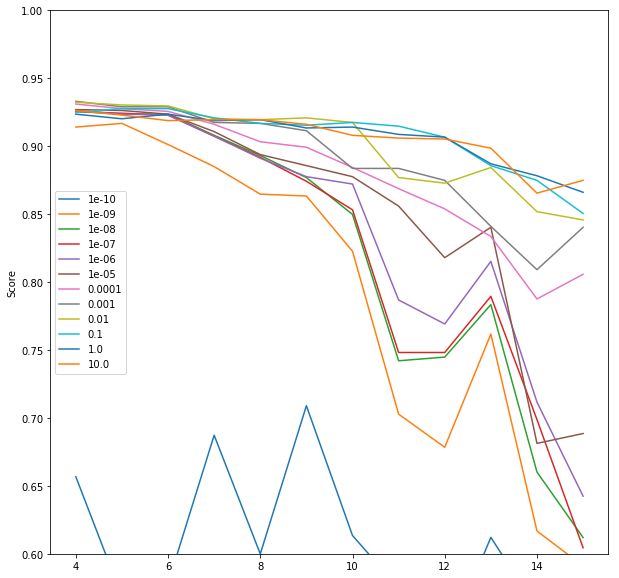

(array([[9.38338702e-02, 9.38347713e-02, 9.38348680e-02, 9.38348790e-02,
         9.38349956e-02, 9.38410094e-02, 9.39077977e-02, 9.45302708e-02,
         9.79211415e-02, 1.09632263e-01, 1.34708486e-01, 1.78540872e-01],
        [8.91356211e-02, 8.91363690e-02, 8.91364491e-02, 8.91364632e-02,
         8.91370016e-02, 8.91595087e-02, 8.93304015e-02, 8.99675968e-02,
         9.32473853e-02, 1.06523451e-01, 1.28818949e-01, 1.76295771e-01],
        [8.54070792e-02, 8.54082892e-02, 8.54084182e-02, 8.54084440e-02,
         8.54095948e-02, 8.54595651e-02, 8.58015671e-02, 8.67544329e-02,
         9.05735149e-02, 1.02599993e-01, 1.25352856e-01, 1.74395260e-01],
        [8.23489379e-02, 8.23501482e-02, 8.23502774e-02, 8.23503545e-02,
         8.23555915e-02, 8.25000995e-02, 8.31303440e-02, 8.46161313e-02,
         8.89616413e-02, 1.00362650e-01, 1.24007026e-01, 1.65374188e-01],
        [7.87222616e-02, 7.87249580e-02, 7.87252456e-02, 7.87254431e-02,
         7.87355944e-02, 7.88594624e-02, 7.9481

In [49]:
param_test_simultane(data_list[7][0], data_list[7][1],6)